In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict



from dotenv import load_dotenv
load_dotenv()

True

In [16]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = data_root + "data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = data_root + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
#simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
#simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
#simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 5, 200), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,20),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    #'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}
import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [7]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###
regr_xgb = XGBRegressor(n_jobs=-1)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=2)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_winddirection'],
      dtype='object')


In [9]:
### HYPERPARAM TUNING WITH GRID-SEARCH + BORUTA SHAP ###
regr_xgb = XGBRegressor()

param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 10, 500), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,10),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    #'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}

model = BoostRFE(
    regr_xgb, param_grid=param_dist_hyperopt, min_features_to_select=5, step=1,
    n_iter=20, sampling_seed=0,
    importance_type='shap_importances', train_importance=False, n_jobs=-1, verbose=0
)

model.fit(
    X_train, y_train, trials=Trials(), 
    eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0
)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')
removed columns Index(['mvbc_WandelaarMeasuringpile_Air_temperature'], dtype='object')


In [10]:
### HYPERPARAM TUNING WITH GRID-SEARCH + BORUTA SHAP ###
regr_xgb = XGBRegressor()

param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 10, 500), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,15),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}

model = BoostRFE(
    regr_xgb, param_grid=param_dist_hyperopt, min_features_to_select=5, step=1,
    n_iter=50, sampling_seed=0,
    importance_type='shap_importances', train_importance=False, n_jobs=-1, verbose=0
)

model.fit(
    X_train, y_train, trials=Trials(), 
    eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0
)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')
removed columns Index([], dtype='object')


In [11]:
# Look at all available data!

scada_inputs = make_dataset.get_scada_subset(data)
inputs = \
    pd.concat(
        [
            mvbc_data[~mvbc_data.index.duplicated(keep='first')],
            scada_inputs
        ],
        axis=1
    )
prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### RECURSIVE FEATURE ELIMINATION (RFE) ###
regr_xgb = XGBRegressor(colsample_bytree=1.0) #early_stopping_rounds=2)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                  #param_grid=param_dist_hyperopt, n_iter=30, sampling_seed=2, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, trials=Trials())

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

### RECURSIVE FEATURE ELIMINATION (RFE) ###
regr_xgb = XGBRegressor(colsample_bytree=0.1) #early_stopping_rounds=2)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                  #param_grid=param_dist_hyperopt, n_iter=30, sampling_seed=2, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, trials=Trials())

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 10, 500), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,15),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}

### RECURSIVE FEATURE ELIMINATION (RFE) ###
regr_xgb = XGBRegressor() #early_stopping_rounds=2)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                  param_grid=param_dist_hyperopt, n_iter=30, sampling_seed=2, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, trials=Trials(), eval_metric='mae')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

0.2908762608020229
5.914030277970425e-06
0.0017605964239795103
0.008014012203155991
kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_winddirection'],
      dtype='object')
0.26981212835662

In [13]:
param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 10, 500), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,15),
    'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    #'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}

### RECURSIVE FEATURE ELIMINATION (RFE) ###
regr_xgb = XGBRegressor(colsample_bytree=1) #early_stopping_rounds=2)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                  param_grid=param_dist_hyperopt, n_iter=30, sampling_seed=2, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, trials=Trials(), eval_metric='mape')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])


30 trials detected for ('n_estimators', 'max_depth', 'learning_rate')

trial: 0001 ### iterations: 00268 ### eval_score: 0.00809
trial: 0002 ### iterations: 00434 ### eval_score: 0.00817
trial: 0003 ### iterations: 00428 ### eval_score: 0.00808
trial: 0004 ### iterations: 00069 ### eval_score: 0.00769
trial: 0005 ### iterations: 00214 ### eval_score: 0.00777
trial: 0006 ### iterations: 00045 ### eval_score: 0.00777
trial: 0007 ### iterations: 00327 ### eval_score: 0.00789
trial: 0008 ### iterations: 00070 ### eval_score: 0.00799
trial: 0009 ### iterations: 00406 ### eval_score: 0.00838
trial: 0010 ### iterations: 00163 ### eval_score: 0.008
trial: 0011 ### iterations: 00261 ### eval_score: 0.00807
trial: 0012 ### iterations: 00301 ### eval_score: 0.00793
trial: 0013 ### iterations: 00024 ### eval_score: 0.00854
trial: 0014 ### iterations: 00380 ### eval_score: 0.00843
trial: 0015 ### iterations: 00039 ### eval_score: 0.00795
trial: 0016 ### iterations: 00378 ### eval_score: 0.00768
tr

In [78]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

param_dist_hyperopt = {
    'n_estimators': hp.uniformint('n_estimators', 10, 500), # 100 to 200
    'max_depth':hp.uniformint('max_depth',2,10),
    #'learning_rate':hp.uniform('learning_rate',0.01,0.5),
    #'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1.0),
}

regr_xgb = XGBRegressor() #early_stopping_rounds=2)
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                 min_features_to_select=2,
                  param_grid=param_dist_hyperopt, n_iter=10, sampling_seed=2, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', verbose=2, trials=Trials())

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])


10 trials detected for ('n_estimators', 'max_depth')

trial: 0001 ### iterations: 00268 ### eval_score: 0.00176
trial: 0002 ### iterations: 00434 ### eval_score: 0.00176
trial: 0003 ### iterations: 00428 ### eval_score: 0.00179
trial: 0004 ### iterations: 00069 ### eval_score: 0.00171
trial: 0005 ### iterations: 00214 ### eval_score: 0.00174
trial: 0006 ### iterations: 00045 ### eval_score: 0.00171
trial: 0007 ### iterations: 00327 ### eval_score: 0.00174
trial: 0008 ### iterations: 00070 ### eval_score: 0.00179
trial: 0009 ### iterations: 00406 ### eval_score: 0.00179
trial: 0010 ### iterations: 00163 ### eval_score: 0.00179
0.33408666271732945
5.553659286104577e-06
0.0017095694263992856
0.007782368782690498
kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_

In [79]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=2)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_winddirection'],
      dtype='object')


In [50]:
scada_inputs = make_dataset.get_scada_subset(data)
inputs = \
    pd.concat(
        [
            mvbc_data[~mvbc_data.index.duplicated(keep='first')],
            scada_inputs
        ],
        axis=1
    )
prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regr_xgb = XGBRegressor(early_stopping_rounds=6)

#model = BoostRFE(
#    regr_xgb, param_grid=param_dist_hyperopt, min_features_to_select=5, step=6,
#    n_iter=20, sampling_seed=0,
#    importance_type='shap_importances', train_importance=False, n_jobs=-1, verbose=2)

### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True,
                  param_grid=param_dist_hyperopt, min_features_to_select=5, n_iter=50, sampling_seed=0, n_jobs=-1
                  )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, trials=Trials())

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


50 trials detected for ('n_estimators', 'max_depth', 'learning_rate', 'colsample_bytree')

trial: 0001 ### iterations: 00009 ### eval_score: 0.00249
trial: 0002 ### iterations: 00017 ### eval_score: 0.00247
trial: 0003 ### iterations: 00010 ### eval_score: 0.0025
trial: 0004 ### iterations: 00075 ### eval_score: 0.00235
trial: 0005 ### iterations: 00026 ### eval_score: 0.00245
trial: 0006 ### iterations: 00021 ### eval_score: 0.00238
trial: 0007 ### iterations: 00014 ### eval_score: 0.00255
trial: 0008 ### iterations: 00028 ### eval_score: 0.00246
trial: 0009 ### iterations: 00017 ### eval_score: 0.00247
trial: 0010 ### iterations: 00012 ### eval_score: 0.00254
trial: 0011 ### iterations: 00051 ### eval_score: 0.00237
trial: 0012 ### iterations: 00161 ### eval_score: 0.00237
trial: 0013 ### iterations: 00037 ### eval_score: 0.00233
trial: 0014 ### iterations: 00011 ### eval_score: 0.00236
trial: 0015 ### iterations: 00023 ### eval_score: 0.00233
trial: 0016 ### iterations: 00019 ### e

In [57]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

0.42127337922420083

In [51]:
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarMeasuringpile_Relative_humidity', 'mean_NW2_D01_winddirection'], dtype='object')


In [52]:
model.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2])

In [53]:
model.score_history_

[0.00234595459255379,
 0.0023360524685796,
 0.00232101960599235,
 0.002346693108293,
 0.0023383078413009,
 0.00234151072791246,
 0.00234665745045514,
 0.0023427383162791,
 0.00232517217911238,
 0.00235912040134002,
 0.00233607078734897,
 0.00233826538349033,
 0.00232576431895898,
 0.00233309140773611]

In [54]:
X.columns[model.support_]

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed'],
      dtype='object')

In [ ]:
import shap
explainer = shap.TreeExplainer(
    model, feature_perturbation="tree_path_dependent")
coefs = explainer.shap_values(X)

In [ ]:
model.shap_importances_

In [33]:
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

estimator = XGBRegressor()
model = BoostBoruta(
    estimator,                              # LGBModel or XGBModel
    perc=100,                               # threshold used to compare shadow and real features
    alpha=0.05,                             # p-value levels for feature rejection
    max_iter=100,                           # maximum Boruta iterations to perform
    early_stopping_boruta_rounds=None,      # maximum iterations without confirming a feature
    param_grid=None,                        # parameters to be optimized
    greater_is_better=False,                # minimize or maximize the monitored score
    importance_type='feature_importances',  # which importance measure to use: default or shap
    train_importance=True,                  # where to compute the shap feature importance
    n_iter=None,                            # number of sampled parameter configurations
    sampling_seed=None,                     # the seed used for parameter sampling
    verbose=0,                              # verbosity mode
    n_jobs=4                             # number of jobs to run in parallel
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=0)
print(model.estimator_, model.n_features_)
print(model.score(X_test, y_test))

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) 7
0.2767655573948551


In [59]:
X.columns[model.support_]

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

In [41]:
print(model.best_params_)
print(model.estimator_.score(X_test, y_test))

{'colsample_bytree': 0.6643045408334806, 'learning_rate': 0.07710425883799692, 'max_depth': 19}
0.24690563629663764


In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3)
poly_inputs = poly.fit_transform(inputs.dropna())
poly_inputs


array([[1.00000000e+00, 8.50000000e+01, 1.50000000e+01, ...,
        5.28743864e+04, 4.91724684e+05, 4.57297344e+06],
       [1.00000000e+00, 8.36666667e+01, 1.50000000e+01, ...,
        5.36594032e+04, 5.12872549e+05, 4.90199732e+06],
       [1.00000000e+00, 8.23333333e+01, 1.50000000e+01, ...,
        4.61128829e+04, 5.34625966e+05, 6.19837462e+06],
       ...,
       [1.00000000e+00, 9.00000000e+01, 1.14666667e+01, ...,
        5.22738150e+03, 4.36423724e+04, 3.64361521e+05],
       [1.00000000e+00, 9.00000000e+01, 1.14333333e+01, ...,
        5.48842080e+03, 4.49029812e+04, 3.67369376e+05],
       [1.00000000e+00, 9.00000000e+01, 1.14000000e+01, ...,
        5.73147345e+03, 4.52421649e+04, 3.57125180e+05]])

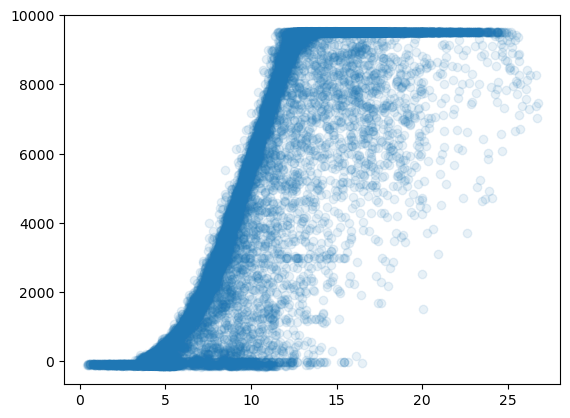

In [10]:
import matplotlib.pyplot as plt
plt.scatter(inputs['mean_NW2_D01_windspeed'], inputs['mean_NW2_D01_power'], alpha=0.1)

# Influence Wave period

In [79]:
mvbc_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')

In [90]:
weather_inputs = \
    make_dataset.get_weather_subset(
        mvbc_data,
        weater_parameters = \
            [
                'Wave_height', 
                'Sea_water_temperature', 
                'Tide_TAW', 
                'Air_pressure', 
                'Air_temperature',
                'wave_period'
                #'Relative_humidity' # TOO MANY NANs
            ]
        )

scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import metrics
from hyperopt import hp
from hyperopt import Trials

regr_xgb = XGBRegressor()
regr_xgb.fit(X_train, y_train)
predictions = regr_xgb.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)

print('R2: ', r2)
print('MAE: ', mae)
print('MSE: ', mse)

R2:  0.244151925152174
MAE:  0.0017675397488905555
MSE:  5.827502076729811e-06


In [91]:
weather_inputs = \
    make_dataset.get_weather_subset(
        mvbc_data,
        weater_parameters = \
            [
                'Wave_height', 
                'Sea_water_temperature', 
                'Tide_TAW', 
                'Air_pressure', 
                'Air_temperature'
                #'Relative_humidity' # TOO MANY NANs
            ]
        )

scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import metrics
from hyperopt import hp
from hyperopt import Trials

regr_xgb = XGBRegressor()
regr_xgb.fit(X_train, y_train)
predictions = regr_xgb.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)

print('R2: ', r2)
print('MAE: ', mae)
print('MSE: ', mse)

R2:  0.237632372576712
MAE:  0.0017616353130834326
MSE:  5.877767080289559e-06


In [98]:
scada_data = make_dataset.get_scada_subset(
    data,
    scada_parameters = \
        [
        'rpm', 
        'yaw', 
        'pitch', 
        'power', 
        'windspeed',
        'winddirection',
        ])

inputs = \
    pd.concat(
        [
            mvbc_data[~mvbc_data.index.duplicated(keep='first')],
            scada_data
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

mode = 'SS1'
# Get the data for the prediction
y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import metrics
from hyperopt import hp
from hyperopt import Trials

regr_xgb = XGBRegressor()
regr_xgb.fit(X_train, y_train)
predictions = regr_xgb.predict(X_test)
r2 = metrics.r2_score(y_test, predictions)
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)

print('R2: ', r2)
print('MAE: ', mae)
print('MSE: ', mse)

R2:  0.27769155004732937
MAE:  0.0017810993798052803
MSE:  6.023989618349764e-06


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


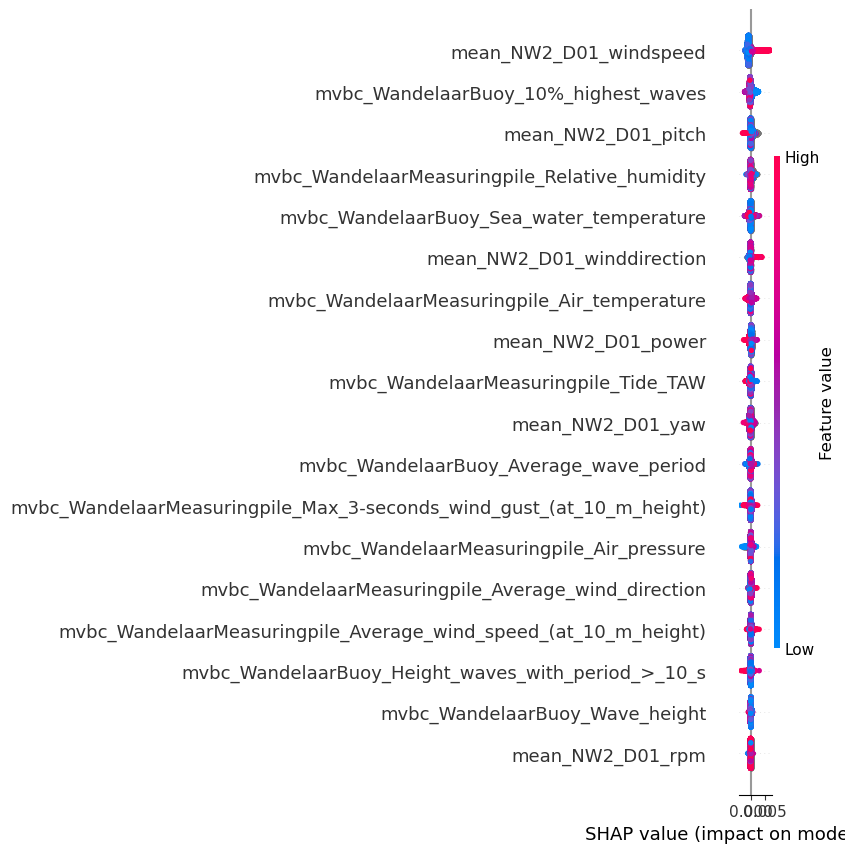

In [99]:
import shap

model = regr_xgb
explainers = shap.Explainer(model)
shap_values = explainers(inputs)
shap.summary_plot(shap_values, inputs)


In [125]:
inputs.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

In [139]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_winddirection'],
      dtype='object')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [126]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances', train_importance=True)
model.fit(X, y, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_winddirection'],
      dtype='object')


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [17]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, min_features_to_select=2)
model.fit(X, y, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed',
       'mean_NW2_D01_winddirection'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mean_NW2_D01_rpm'],
      dtype='object')


In [119]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=1, min_features_to_select=2, early_stopping_rounds=6)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_D01_pitch',
       'mean_NW2_D01_power', 'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_winddirection'],
      dtype='object')


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [116]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=2)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_yaw',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed',
       'mean_NW2_D01_winddirection'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mean_NW2_D01_rpm'],
      dtype='object')


In [117]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(regr_xgb, step=3)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)
print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


kept columns Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mean_NW2_D01_winddirection'],
      dtype='object')


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [129]:
inputs.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

Text(0, 0.5, 'mvbc_WandelaarMeasuringpile_Air_temperature (°C)')

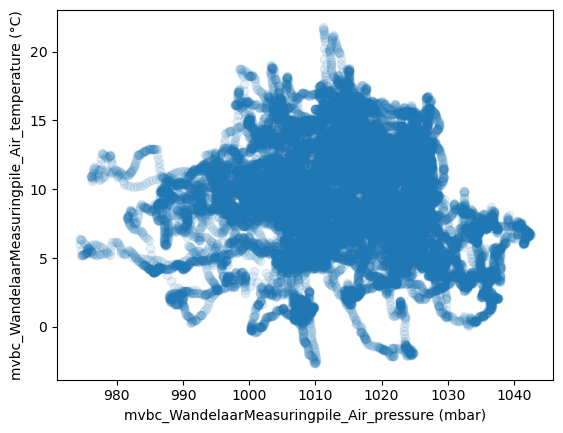

In [150]:
plt.scatter(inputs['mvbc_WandelaarMeasuringpile_Air_pressure'], inputs['mvbc_WandelaarMeasuringpile_Air_temperature'], alpha=0.1)
plt.xlabel(xlabel='mvbc_WandelaarMeasuringpile_Air_pressure (mbar)')
plt.ylabel(ylabel='mvbc_WandelaarMeasuringpile_Air_temperature (°C)')

<Axes: >

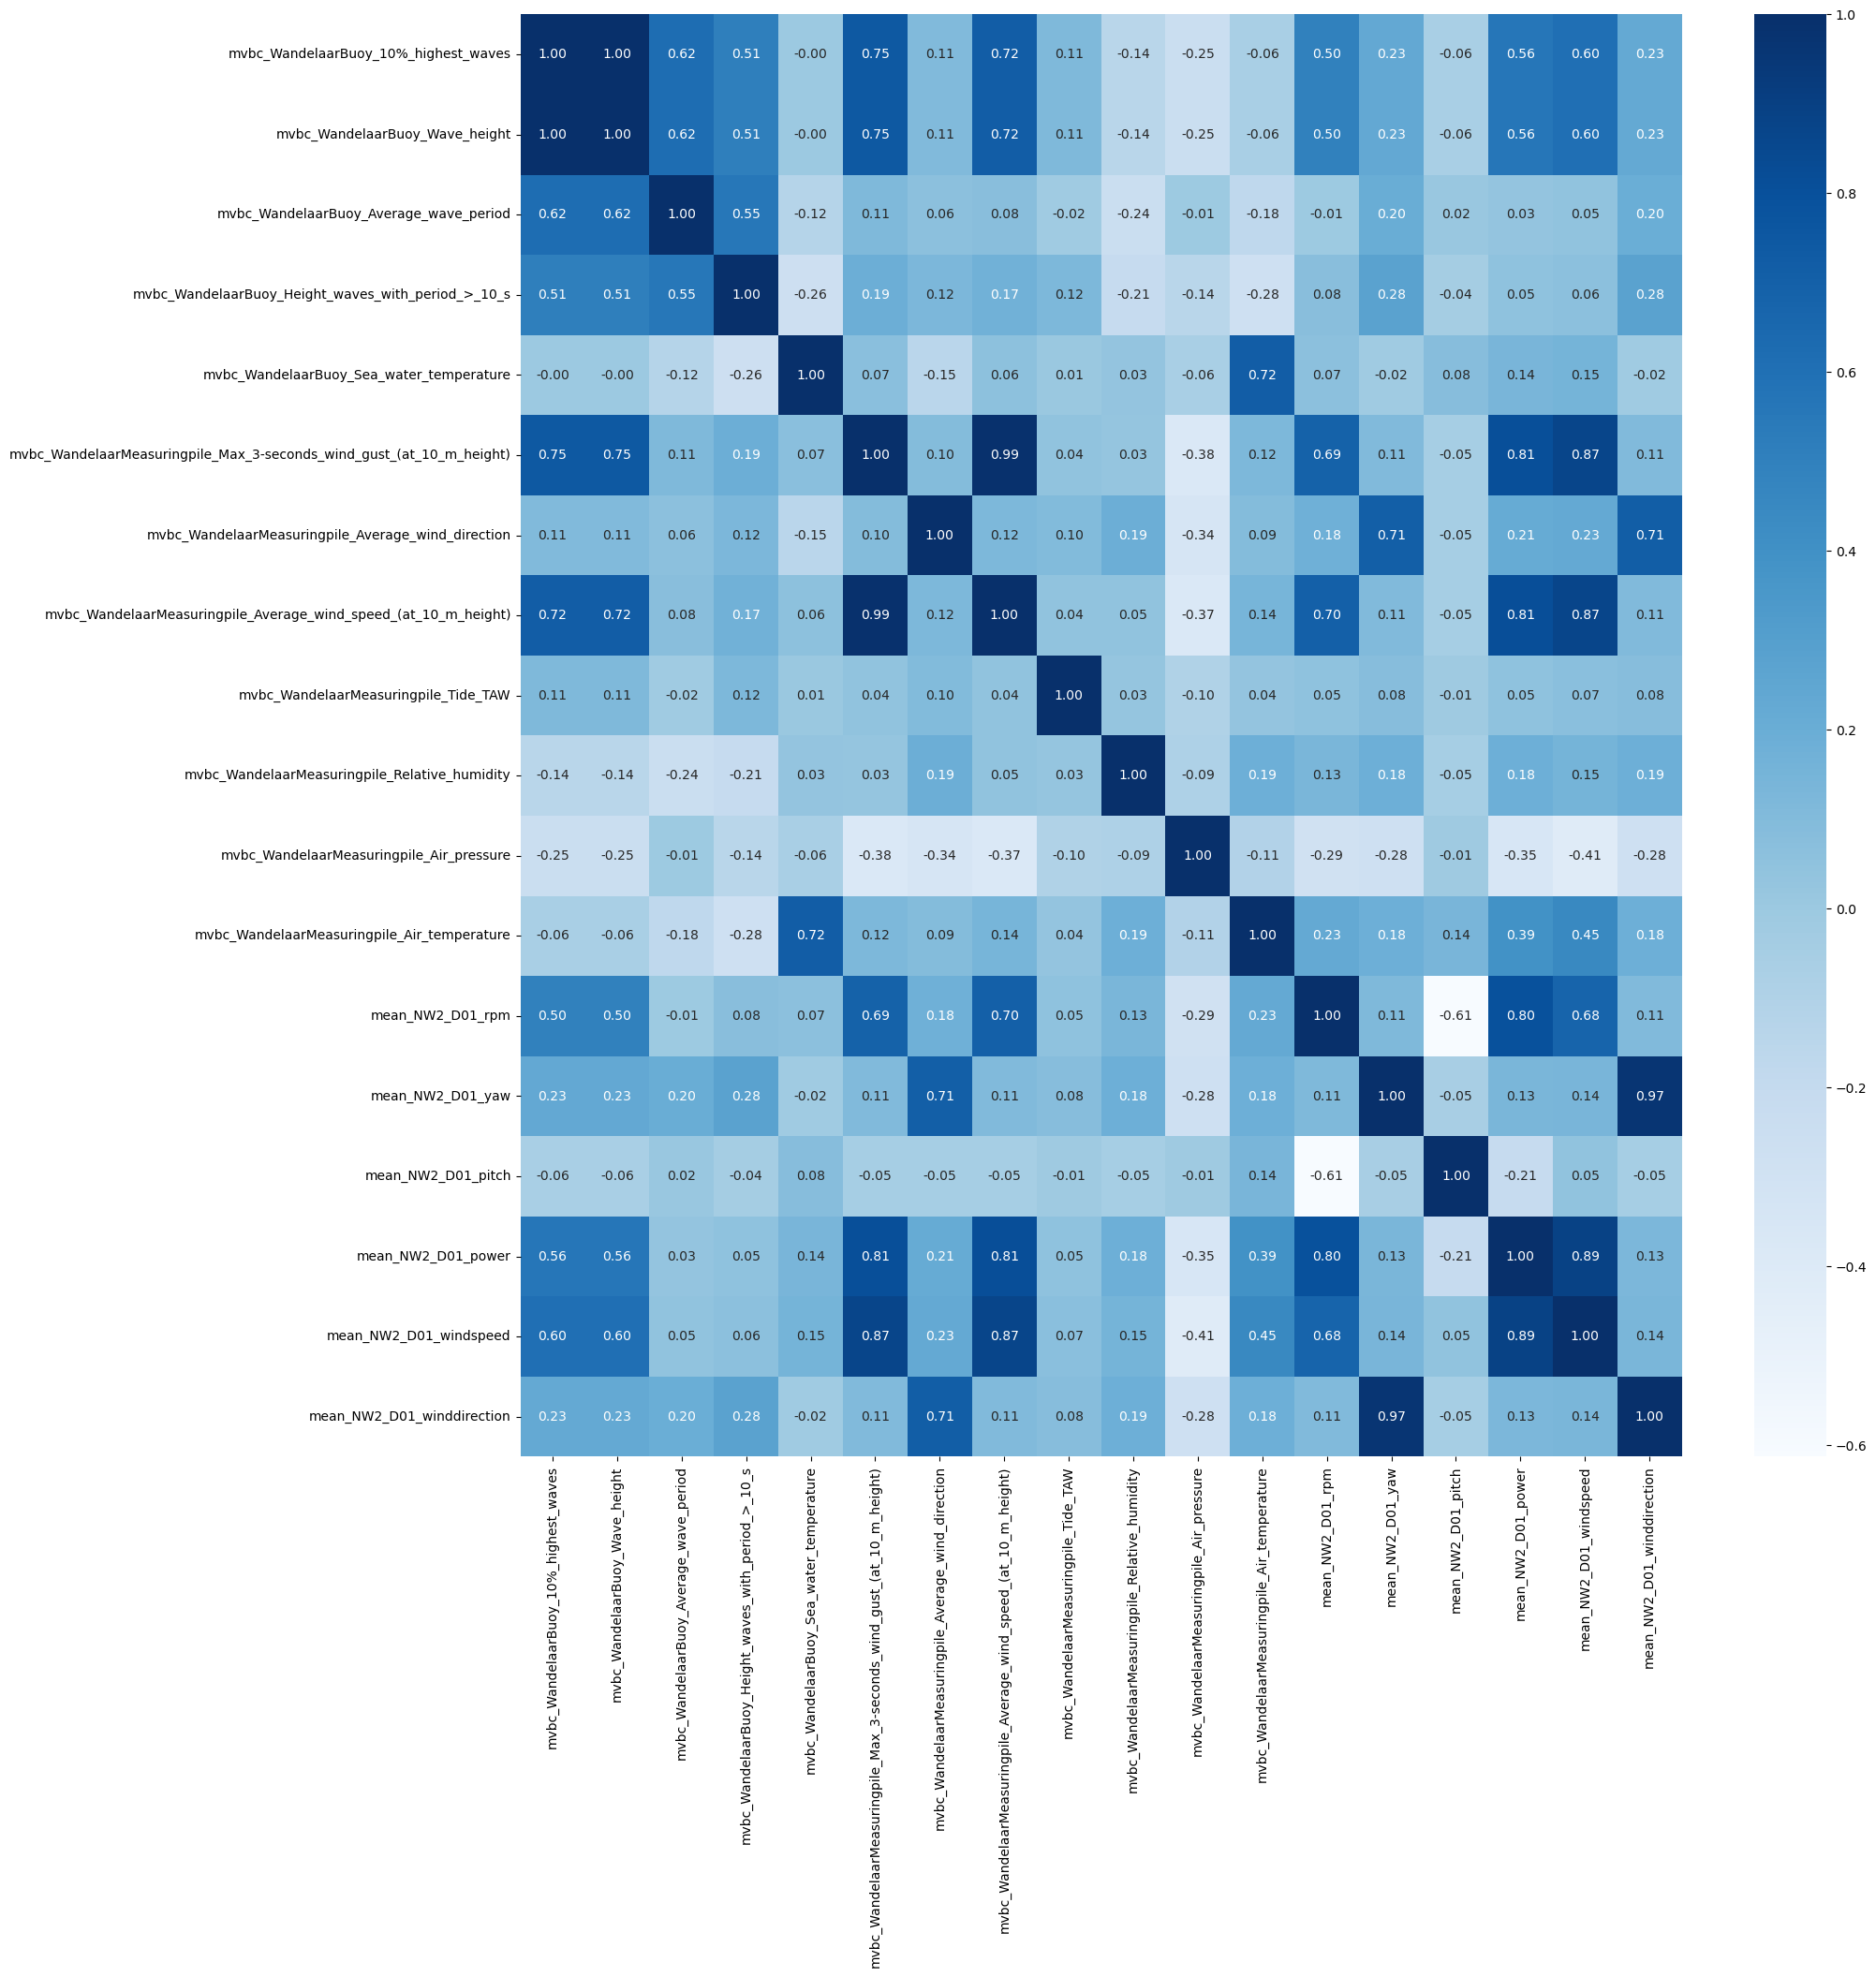

In [149]:
# plot correlation with parameter names as labels in the y axis only
import seaborn as sns
corr = inputs.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', annot_kws={'size': 10}, cmap='Blues')


Text(0, 0.5, 'Sea water temperature (°C)')

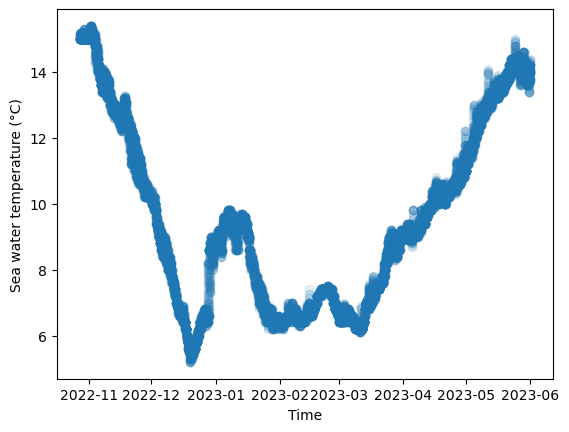

In [140]:
plt.scatter(inputs.index, inputs['mvbc_WandelaarBuoy_Sea_water_temperature'], alpha=0.1)
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='Sea water temperature (°C)')

Text(0, 0.5, 'Wave period (s)')

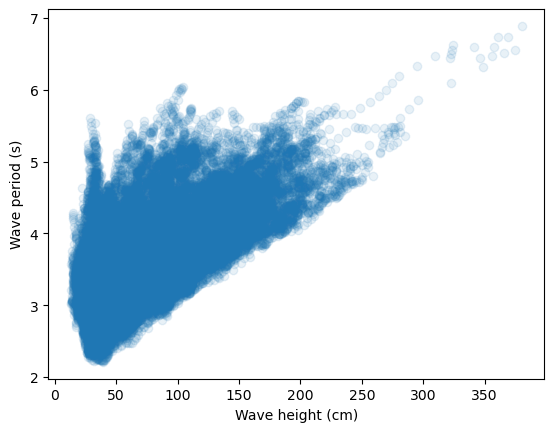

In [141]:
plt.scatter(inputs['mvbc_WandelaarBuoy_Wave_height'], inputs['mvbc_WandelaarBuoy_Average_wave_period'], alpha=0.1)
plt.xlabel(xlabel='Wave height (cm)')
plt.ylabel(ylabel='Wave period (s)')

Text(0, 0.5, 'mvbc_WandelaarBuoy_10%_highest_waves (cm)')

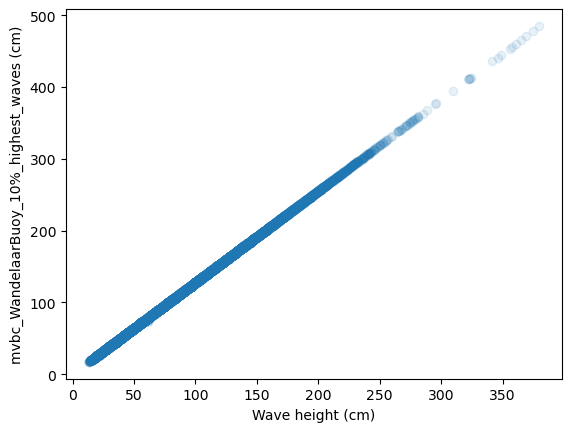

In [137]:
plt.scatter(inputs['mvbc_WandelaarBuoy_Wave_height'], inputs['mvbc_WandelaarBuoy_10%_highest_waves'], alpha=0.1)
plt.xlabel(xlabel='Wave height (cm)')
plt.ylabel(ylabel='mvbc_WandelaarBuoy_10%_highest_waves (cm)')